# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!pip install --q torchsummary

# Resnext - path 2

In [3]:
# Define a block
class GP_Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GP_Block, self).__init__()

        # Path 1
        self.conv1_path1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ELU()
        self.conv2_path1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Path 2
        self.conv1_path2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2_path2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        shortcut = x  # Save the input as a shortcut for the residual connection

        # Path 1
        x1 = self.conv1_path1(x)
        x1 = self.activation(x1)
        x1 = self.conv2_path1(x1)

        # Path 2
        x2 = self.conv1_path2(x)
        x2 = self.activation(x2)
        x2 = self.conv2_path2(x2)

        # Combine paths (element-wise addition)
        x = x1 + x2

        # Final combination with the shortcut (residual connection)
        x += shortcut
        x = self.activation(x)  # Apply activation function to the final output

        return x

# Define the main ResNet model
class MyResNext(nn.Module):
    # Constructor
    def __init__(self):
        super(MyResNext, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.activation1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.activation2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Residual blocks
        self.resblock1 = GP_Block(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.activation3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.activation4 = nn.ELU()
        self.resblock2 = GP_Block(256, 256)

        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256, 256)
        self.dense2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    # Forward method for the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.maxpool1(x)

        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.activation3(x)
        x = self.maxpool2(x)

        x = self.conv4(x)
        x = self.activation4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x


In [6]:
from torchsummary import summary

# Instantiate the model
model = MyResNext()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
               ELU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
               ELU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          36,928
               ELU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
            Conv2d-9           [-1, 64, 16, 16]          36,928
              ELU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
              ELU-12           [-1, 64, 16, 16]               0
         GP_Block-13           [-1, 64, 16, 16]               0
           Conv2d-14          [-1, 128,

# Dataset

In [7]:
# Data augmentation transformations for training data
data_augmentation_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),  # Randomly rotate the image by 15 degrees
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor values
])

# Data preprocessing transformations for test/validation data
data_preprocessing_test = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the tensor values
])


# Load CIFAR-10 dataset
# Training set with data augmentation
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=data_augmentation_train)
# Test set with data preprocessing
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=data_preprocessing_test)

# Splitting the training dataset into training and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
batch_size = 128
# Training data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Test data loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 92698970.82it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Training

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyResNext().to(device)

In [9]:
# Optimizer, Learning Rate Scheduler, and Loss Criterion
# Stochastic Gradient Descent (SGD) optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Learning rate scheduler with step decay
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
# CrossEntropyLoss criterion for classification tasks
criterion = nn.CrossEntropyLoss()

In [10]:
from tqdm import tqdm

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
best_model_weights = None

# Number of epochs
epochs = 100

# Training loop
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_samples += data.size(0)

        total_loss += loss.item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader.dataset)
    accuracy_train = correct / total_samples

    print(f'Train Epoch: {epoch}, Average Loss: {average_loss:.4f}, Accuracy: {accuracy_train:.2}')

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy_val = correct / len(val_loader.dataset)
    print(f'Validation set: Average loss: {val_loss:.4f}, Accuracy: {accuracy_val:.2f}')

    # Append values for plotting
    train_losses.append(average_loss)
    train_accuracies.append(accuracy_train)

    # Append values for plotting
    val_losses.append(val_loss)
    val_accuracies.append(accuracy_val)

    if accuracy_val > best_val_accuracy:
       best_val_accuracy = accuracy_val
       best_model_weights = model.state_dict()

    scheduler.step()

100%|██████████| 352/352 [00:47<00:00,  7.36it/s]


Train Epoch: 1, Average Loss: 0.0180, Accuracy: 0.13
Validation set: Average loss: 0.0182, Accuracy: 0.15


100%|██████████| 352/352 [00:33<00:00, 10.46it/s]


Train Epoch: 2, Average Loss: 0.0175, Accuracy: 0.19
Validation set: Average loss: 0.0179, Accuracy: 0.20


100%|██████████| 352/352 [00:34<00:00, 10.23it/s]


Train Epoch: 3, Average Loss: 0.0173, Accuracy: 0.22
Validation set: Average loss: 0.0177, Accuracy: 0.23


100%|██████████| 352/352 [00:33<00:00, 10.40it/s]


Train Epoch: 4, Average Loss: 0.0171, Accuracy: 0.26
Validation set: Average loss: 0.0174, Accuracy: 0.27


100%|██████████| 352/352 [00:33<00:00, 10.43it/s]


Train Epoch: 5, Average Loss: 0.0168, Accuracy: 0.3
Validation set: Average loss: 0.0173, Accuracy: 0.29


100%|██████████| 352/352 [00:33<00:00, 10.47it/s]


Train Epoch: 6, Average Loss: 0.0166, Accuracy: 0.33
Validation set: Average loss: 0.0170, Accuracy: 0.33


100%|██████████| 352/352 [00:33<00:00, 10.41it/s]


Train Epoch: 7, Average Loss: 0.0164, Accuracy: 0.35
Validation set: Average loss: 0.0167, Accuracy: 0.37


100%|██████████| 352/352 [00:33<00:00, 10.64it/s]


Train Epoch: 8, Average Loss: 0.0162, Accuracy: 0.38
Validation set: Average loss: 0.0167, Accuracy: 0.38


100%|██████████| 352/352 [00:33<00:00, 10.59it/s]


Train Epoch: 9, Average Loss: 0.0161, Accuracy: 0.4
Validation set: Average loss: 0.0165, Accuracy: 0.40


100%|██████████| 352/352 [00:33<00:00, 10.44it/s]


Train Epoch: 10, Average Loss: 0.0159, Accuracy: 0.42
Validation set: Average loss: 0.0163, Accuracy: 0.42


100%|██████████| 352/352 [00:32<00:00, 10.76it/s]


Train Epoch: 11, Average Loss: 0.0158, Accuracy: 0.44
Validation set: Average loss: 0.0162, Accuracy: 0.43


100%|██████████| 352/352 [00:34<00:00, 10.34it/s]


Train Epoch: 12, Average Loss: 0.0157, Accuracy: 0.45
Validation set: Average loss: 0.0161, Accuracy: 0.46


100%|██████████| 352/352 [00:34<00:00, 10.27it/s]


Train Epoch: 13, Average Loss: 0.0156, Accuracy: 0.47
Validation set: Average loss: 0.0160, Accuracy: 0.47


100%|██████████| 352/352 [00:33<00:00, 10.52it/s]


Train Epoch: 14, Average Loss: 0.0155, Accuracy: 0.48
Validation set: Average loss: 0.0159, Accuracy: 0.48


100%|██████████| 352/352 [00:32<00:00, 10.72it/s]


Train Epoch: 15, Average Loss: 0.0153, Accuracy: 0.5
Validation set: Average loss: 0.0158, Accuracy: 0.48


100%|██████████| 352/352 [00:33<00:00, 10.64it/s]


Train Epoch: 16, Average Loss: 0.0153, Accuracy: 0.5
Validation set: Average loss: 0.0156, Accuracy: 0.52


100%|██████████| 352/352 [00:34<00:00, 10.29it/s]


Train Epoch: 17, Average Loss: 0.0152, Accuracy: 0.52
Validation set: Average loss: 0.0159, Accuracy: 0.48


100%|██████████| 352/352 [00:33<00:00, 10.59it/s]


Train Epoch: 18, Average Loss: 0.0151, Accuracy: 0.53
Validation set: Average loss: 0.0154, Accuracy: 0.54


100%|██████████| 352/352 [00:33<00:00, 10.47it/s]


Train Epoch: 19, Average Loss: 0.0149, Accuracy: 0.55
Validation set: Average loss: 0.0153, Accuracy: 0.55


100%|██████████| 352/352 [00:33<00:00, 10.51it/s]


Train Epoch: 20, Average Loss: 0.0148, Accuracy: 0.57
Validation set: Average loss: 0.0151, Accuracy: 0.58


100%|██████████| 352/352 [00:33<00:00, 10.62it/s]


Train Epoch: 21, Average Loss: 0.0147, Accuracy: 0.58
Validation set: Average loss: 0.0149, Accuracy: 0.59


100%|██████████| 352/352 [00:33<00:00, 10.47it/s]


Train Epoch: 22, Average Loss: 0.0146, Accuracy: 0.6
Validation set: Average loss: 0.0150, Accuracy: 0.59


100%|██████████| 352/352 [00:33<00:00, 10.43it/s]


Train Epoch: 23, Average Loss: 0.0145, Accuracy: 0.61
Validation set: Average loss: 0.0149, Accuracy: 0.61


100%|██████████| 352/352 [00:33<00:00, 10.46it/s]


Train Epoch: 24, Average Loss: 0.0144, Accuracy: 0.62
Validation set: Average loss: 0.0148, Accuracy: 0.61


100%|██████████| 352/352 [00:33<00:00, 10.61it/s]


Train Epoch: 25, Average Loss: 0.0143, Accuracy: 0.62
Validation set: Average loss: 0.0147, Accuracy: 0.62


100%|██████████| 352/352 [00:33<00:00, 10.60it/s]


Train Epoch: 26, Average Loss: 0.0143, Accuracy: 0.63
Validation set: Average loss: 0.0149, Accuracy: 0.60


100%|██████████| 352/352 [00:33<00:00, 10.43it/s]


Train Epoch: 27, Average Loss: 0.0142, Accuracy: 0.64
Validation set: Average loss: 0.0149, Accuracy: 0.60


100%|██████████| 352/352 [00:32<00:00, 10.76it/s]


Train Epoch: 28, Average Loss: 0.0142, Accuracy: 0.64
Validation set: Average loss: 0.0147, Accuracy: 0.63


100%|██████████| 352/352 [00:33<00:00, 10.53it/s]


Train Epoch: 29, Average Loss: 0.0141, Accuracy: 0.65
Validation set: Average loss: 0.0147, Accuracy: 0.63


100%|██████████| 352/352 [00:32<00:00, 10.71it/s]


Train Epoch: 30, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0145, Accuracy: 0.66


100%|██████████| 352/352 [00:33<00:00, 10.60it/s]


Train Epoch: 31, Average Loss: 0.0141, Accuracy: 0.66
Validation set: Average loss: 0.0145, Accuracy: 0.66


100%|██████████| 352/352 [00:33<00:00, 10.50it/s]


Train Epoch: 32, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0145, Accuracy: 0.65


100%|██████████| 352/352 [00:32<00:00, 10.72it/s]


Train Epoch: 33, Average Loss: 0.0140, Accuracy: 0.67
Validation set: Average loss: 0.0144, Accuracy: 0.66


100%|██████████| 352/352 [00:34<00:00, 10.23it/s]


Train Epoch: 34, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:33<00:00, 10.48it/s]


Train Epoch: 35, Average Loss: 0.0139, Accuracy: 0.68
Validation set: Average loss: 0.0144, Accuracy: 0.67


100%|██████████| 352/352 [00:33<00:00, 10.49it/s]


Train Epoch: 36, Average Loss: 0.0138, Accuracy: 0.69
Validation set: Average loss: 0.0143, Accuracy: 0.67


100%|██████████| 352/352 [00:33<00:00, 10.48it/s]


Train Epoch: 37, Average Loss: 0.0138, Accuracy: 0.7
Validation set: Average loss: 0.0143, Accuracy: 0.68


100%|██████████| 352/352 [00:32<00:00, 10.69it/s]


Train Epoch: 38, Average Loss: 0.0138, Accuracy: 0.7
Validation set: Average loss: 0.0142, Accuracy: 0.69


100%|██████████| 352/352 [00:33<00:00, 10.39it/s]


Train Epoch: 39, Average Loss: 0.0137, Accuracy: 0.7
Validation set: Average loss: 0.0142, Accuracy: 0.69


100%|██████████| 352/352 [00:33<00:00, 10.67it/s]


Train Epoch: 40, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0141, Accuracy: 0.69


100%|██████████| 352/352 [00:33<00:00, 10.50it/s]


Train Epoch: 41, Average Loss: 0.0137, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:33<00:00, 10.63it/s]


Train Epoch: 42, Average Loss: 0.0137, Accuracy: 0.71
Validation set: Average loss: 0.0142, Accuracy: 0.69


100%|██████████| 352/352 [00:33<00:00, 10.50it/s]


Train Epoch: 43, Average Loss: 0.0136, Accuracy: 0.72
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:35<00:00, 10.02it/s]


Train Epoch: 44, Average Loss: 0.0136, Accuracy: 0.73
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:33<00:00, 10.55it/s]


Train Epoch: 45, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.70


100%|██████████| 352/352 [00:33<00:00, 10.61it/s]


Train Epoch: 46, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:33<00:00, 10.37it/s]


Train Epoch: 47, Average Loss: 0.0135, Accuracy: 0.73
Validation set: Average loss: 0.0141, Accuracy: 0.71


100%|██████████| 352/352 [00:33<00:00, 10.61it/s]


Train Epoch: 48, Average Loss: 0.0135, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.72


100%|██████████| 352/352 [00:34<00:00, 10.24it/s]


Train Epoch: 49, Average Loss: 0.0134, Accuracy: 0.74
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:33<00:00, 10.53it/s]


Train Epoch: 50, Average Loss: 0.0134, Accuracy: 0.75
Validation set: Average loss: 0.0140, Accuracy: 0.71


100%|██████████| 352/352 [00:33<00:00, 10.60it/s]


Train Epoch: 51, Average Loss: 0.0132, Accuracy: 0.77
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:34<00:00, 10.27it/s]


Train Epoch: 52, Average Loss: 0.0132, Accuracy: 0.78
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:33<00:00, 10.62it/s]


Train Epoch: 53, Average Loss: 0.0131, Accuracy: 0.78
Validation set: Average loss: 0.0138, Accuracy: 0.75


100%|██████████| 352/352 [00:35<00:00, 10.05it/s]


Train Epoch: 54, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:32<00:00, 10.68it/s]


Train Epoch: 55, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:32<00:00, 10.69it/s]


Train Epoch: 56, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:34<00:00, 10.35it/s]


Train Epoch: 57, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.63it/s]


Train Epoch: 58, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:33<00:00, 10.37it/s]


Train Epoch: 59, Average Loss: 0.0130, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.59it/s]


Train Epoch: 60, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:33<00:00, 10.62it/s]


Train Epoch: 61, Average Loss: 0.0131, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.46it/s]


Train Epoch: 62, Average Loss: 0.0130, Accuracy: 0.79
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:33<00:00, 10.66it/s]


Train Epoch: 63, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:34<00:00, 10.14it/s]


Train Epoch: 64, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0137, Accuracy: 0.75


100%|██████████| 352/352 [00:33<00:00, 10.59it/s]


Train Epoch: 65, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.66it/s]


Train Epoch: 66, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.37it/s]


Train Epoch: 67, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.64it/s]


Train Epoch: 68, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:34<00:00, 10.30it/s]


Train Epoch: 69, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.61it/s]


Train Epoch: 70, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:32<00:00, 10.69it/s]


Train Epoch: 71, Average Loss: 0.0130, Accuracy: 0.81
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:34<00:00, 10.26it/s]


Train Epoch: 72, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.65it/s]


Train Epoch: 73, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.38it/s]


Train Epoch: 74, Average Loss: 0.0130, Accuracy: 0.8
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.26it/s]


Train Epoch: 75, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.52it/s]


Train Epoch: 76, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.37it/s]


Train Epoch: 77, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.58it/s]


Train Epoch: 78, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0137, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.46it/s]


Train Epoch: 79, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.58it/s]


Train Epoch: 80, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:32<00:00, 10.72it/s]


Train Epoch: 81, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.45it/s]


Train Epoch: 82, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.62it/s]


Train Epoch: 83, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.28it/s]


Train Epoch: 84, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.14it/s]


Train Epoch: 85, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.55it/s]


Train Epoch: 86, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.27it/s]


Train Epoch: 87, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:32<00:00, 10.69it/s]


Train Epoch: 88, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.51it/s]


Train Epoch: 89, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.42it/s]


Train Epoch: 90, Average Loss: 0.0129, Accuracy: 0.81
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:32<00:00, 10.72it/s]


Train Epoch: 91, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.29it/s]


Train Epoch: 92, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:32<00:00, 10.78it/s]


Train Epoch: 93, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.45it/s]


Train Epoch: 94, Average Loss: 0.0129, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.11it/s]


Train Epoch: 95, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:32<00:00, 10.76it/s]


Train Epoch: 96, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:34<00:00, 10.32it/s]


Train Epoch: 97, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.76


100%|██████████| 352/352 [00:33<00:00, 10.61it/s]


Train Epoch: 98, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


100%|██████████| 352/352 [00:33<00:00, 10.43it/s]


Train Epoch: 99, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0136, Accuracy: 0.77


100%|██████████| 352/352 [00:33<00:00, 10.45it/s]


Train Epoch: 100, Average Loss: 0.0128, Accuracy: 0.82
Validation set: Average loss: 0.0135, Accuracy: 0.78


In [11]:
# Test the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}')

Test set: Average loss: 0.0132, Accuracy: 0.78


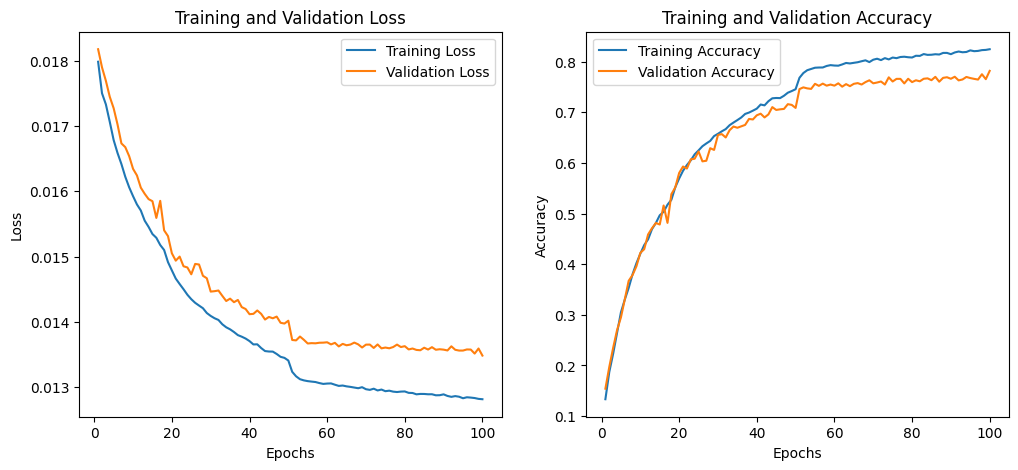

In [12]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [13]:
torch.save(model.state_dict(), 'trained_MyResNext_path2.pth')

# Metrics

In [6]:
!git clone https://github.com/K-Hooshanfar/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 3.62 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [7]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex
import torch
from tqdm import tqdm

In [10]:
# Load the pre-trained model
state_dict = torch.load('/content/trained_MyResNext_path2.pth')

model = MyResNext()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Convert test_dataset to a list or NumPy array
test_data_list = [(img, label) for img, label in test_dataset]

# Further split train_dataset into train_loader_dataset and 10% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.1 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Similarly, for the test_loader
test_loader_dataset, _ = train_test_split(test_data_list, train_size=int(0.1 * len(test_dataset)),
                                          test_size=None, shuffle=True, stratify=test_dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_loader_dataset, batch_size=128, shuffle=False)


100%|██████████| 170498071/170498071 [00:02<00:00, 79798537.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
features_per_layer = {}
labels = []

# Get the total number of layers in the model
total_layers = len(list(model.children()))

# Exclude the last four layers
layers_to_be_deleted = set(list(model.children())[-4:])

# Attach hooks to each layer except the excluded ones
features_per_layer = {}
for name, layer in model.named_children():
    if layer not in layers_to_be_deleted:
        features_per_layer[name] = []
        def hook(module, input, output, name=name):
            features_per_layer[name].append(output.detach())
        layer.register_forward_hook(hook)

In [13]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 36/36 [00:07<00:00,  4.84it/s]


# SI

In [14]:
si_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 371.35it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1822.50it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 5317.32it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 502.43it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4524.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1951.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1301.37it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1374.19it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1347.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 4673.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3155.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3166.95it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 1060.61it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 3904.58it/s]


In [15]:
si_train

[('conv1', 0.23044444620609283),
 ('activation1', 0.22733333706855774),
 ('conv2', 0.2235555648803711),
 ('activation2', 0.22555555403232574),
 ('maxpool1', 0.2953333258628845),
 ('resblock1', 0.33177778124809265),
 ('maxpool2', 0.4399999976158142),
 ('conv3', 0.4020000100135803),
 ('activation3', 0.3646666705608368),
 ('maxpool3', 0.5444444417953491),
 ('conv4', 0.5397777557373047),
 ('activation4', 0.4873333275318146),
 ('resblock2', 0.6200000047683716),
 ('avgpool', 0.6899999976158142)]

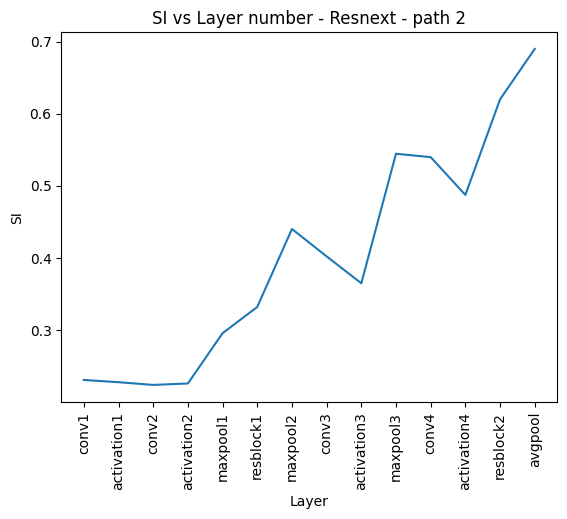

In [16]:
plt.plot([layer for layer, _ in si_train], [si for _, si in si_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number - Resnext - path 2')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [17]:
csi_train = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1154.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1285.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2057.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1613.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1243.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1859.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2000.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1770.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1149.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1327.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1356.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1314.09it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1286.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 1823.61it/s]


In [18]:
csi_train

[('conv1', 0.3779999911785126),
 ('activation1', 0.38111111521720886),
 ('conv2', 0.3728888928890228),
 ('activation2', 0.39888888597488403),
 ('maxpool1', 0.4395555555820465),
 ('resblock1', 0.5435555577278137),
 ('maxpool2', 0.5733333230018616),
 ('conv3', 0.5253333449363708),
 ('activation3', 0.5704444646835327),
 ('maxpool3', 0.6277777552604675),
 ('conv4', 0.554888904094696),
 ('activation4', 0.620888888835907),
 ('resblock2', 0.710444450378418),
 ('avgpool', 0.7635555863380432)]

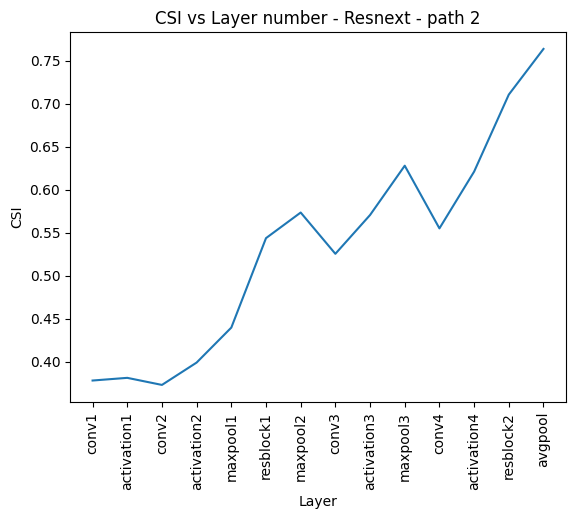

In [19]:
plt.plot([layer for layer, _ in csi_train], [si for _, si in csi_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number - Resnext - path 2')
plt.xticks(rotation=90)
plt.show()

# Metrics of Test Loader

In [14]:
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to(device)
        model(inputs)
        labels.append(targets.cpu())

# Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])

labels = torch.cat(labels)

100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


# SI

In [15]:
si_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=1000)
    si_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 107.46it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2752.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1956.30it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1292.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 820.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2590.68it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 515.97it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2629.66it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 668.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2849.39it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 1888.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3123.09it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 2972.58it/s]


Data has been normalized


Calculating SI: 100%|██████████| 1/1 [00:00<00:00, 3017.48it/s]


In [16]:
si_test

[('conv1', 0.1940000057220459),
 ('activation1', 0.19500000774860382),
 ('conv2', 0.1980000138282776),
 ('activation2', 0.20000000298023224),
 ('maxpool1', 0.24000000953674316),
 ('resblock1', 0.28300002217292786),
 ('maxpool2', 0.3570000231266022),
 ('conv3', 0.32500001788139343),
 ('activation3', 0.30400002002716064),
 ('maxpool3', 0.46000000834465027),
 ('conv4', 0.46000000834465027),
 ('activation4', 0.4240000247955322),
 ('resblock2', 0.5410000085830688),
 ('avgpool', 0.5850000381469727)]

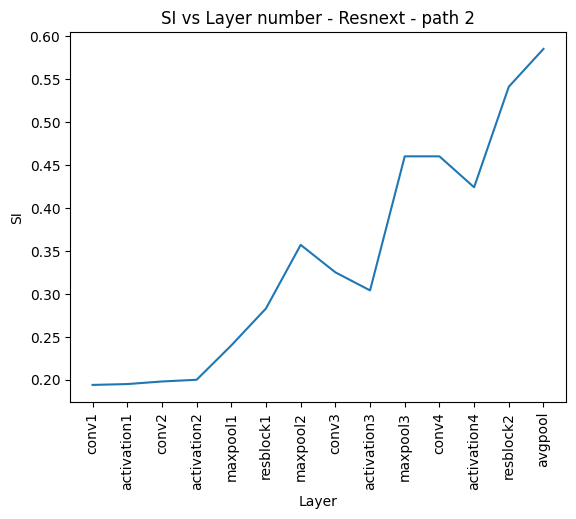

In [17]:
plt.plot([layer for layer, _ in si_test], [si for _, si in si_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('SI vs Layer number - Resnext - path 2')
plt.xticks(rotation=90)
plt.show()

# Center Si

In [18]:
csi_test = []

for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=1000)
    csi_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 597.91it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1397.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1303.39it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 733.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 459.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 594.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1906.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 739.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 525.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1333.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 652.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 661.46it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 823.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 1/1 [00:00<00:00, 1343.90it/s]


In [19]:
csi_test

[('conv1', 0.42900002002716064),
 ('activation1', 0.4320000112056732),
 ('conv2', 0.4310000240802765),
 ('activation2', 0.4620000123977661),
 ('maxpool1', 0.492000013589859),
 ('resblock1', 0.6290000081062317),
 ('maxpool2', 0.6320000290870667),
 ('conv3', 0.5860000252723694),
 ('activation3', 0.6410000324249268),
 ('maxpool3', 0.6780000329017639),
 ('conv4', 0.6000000238418579),
 ('activation4', 0.7100000381469727),
 ('resblock2', 0.7410000562667847),
 ('avgpool', 0.7200000286102295)]

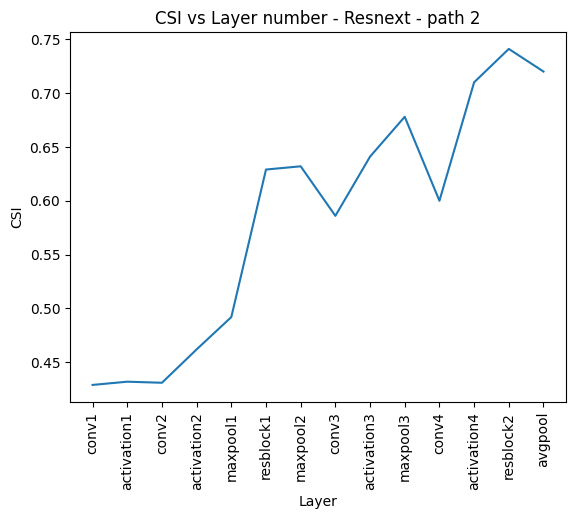

In [20]:
plt.plot([layer for layer, _ in csi_test], [si for _, si in csi_test])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('CSI vs Layer number - Resnext - path 2')
plt.xticks(rotation=90)
plt.show()